In [3]:
import rasterio
from shapely.geometry import mapping
import os
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
from rasterio import features
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer
from scipy.ndimage import uniform_filter
import elevation
import tempfile
import seaborn as sns
import osmnx as ox
import pyrosm
from src.utils import DATA_DIR, KILOMETERS_OFFSHORE

In [4]:
# plt.style.use('dark_background')

## load data

In [17]:
def load_vector(fp):
    return gpd.read_file(f'{DATA_DIR}/{fp}', crs='EPSG:4326')


def load_raster(fp, area=None):
    """
    Loads raster data and crops it to the area of interest.
    """
    if area is None and fp.startswith('topography'):
        with rasterio.open(f"{DATA_DIR}/{fp}") as src:
            return src.read(1), src.transform, src.meta
    else:
        geometry = [mapping(polygon) for polygon in area.geometry]
        with rasterio.open(f"{DATA_DIR}/{fp}") as src:
            out_image, out_transform = rasterio.mask.mask(src, geometry, crop=True)
            out_image = out_image[0]
            out_meta = src.meta
            return out_image, out_transform, out_meta

In [4]:
# metrological data
power_density, power_density_transform, power_density_meta = load_raster(f'meterology/gwa3_250_powerdensity_100m.tif', ox.geocode_to_gdf('Bahia, Brazil'))
wind_speed, wind_speed_transform, wind_speed_meta = load_raster(f'meterology/gwa3_250_windspeed_100m.tif', ox.geocode_to_gdf('Bahia, Brazil'))

In [12]:
# population data
population, population_transform, population_meta = load_raster(f'demography/bra_pd_2020_1km.tif', ox.geocode_to_gdf('Bahia, Brazil'))
population[ population < 0 ] = 0

In [73]:
# topography data
topography, topography_transform, topography_meta = load_raster('topography/brazil_dem.tif', ox.geocode_to_gdf('Bahia, Brazil'))
slope, slope_transform, slope_meta = load_raster('topography/slope.tif', ox.geocode_to_gdf('Bahia, Brazil'))
roughness, roughness_transform, roughness_meta = load_raster('topography/roughness.tif', ox.geocode_to_gdf('Bahia, Brazil'))

### vector data

In [10]:
def create_buffer(gdf, km):
    """
    Creates a buffer around a given GeoDataFrame.
    """
    return gdf.geometry.buffer(km * 1000)

def create_buffer_mask(raster, raster_transform, geodataframe, distance):
    # Create a buffer zone around each line
    geodataframe['geometry'] = geodataframe['geometry'].apply(lambda x: x.buffer(distance * 1000))
    
    # Get the shape of the raster data
    out_shape = raster.shape

    # Create a mask
    mask = rasterio.features.rasterize(
        ((geom, 1) for geom in geodataframe.geometry),
        out_shape=out_shape,
        transform=raster_transform,
        fill=1,
        default_value=1,
        dtype=np.uint8)

    return mask

In [19]:
files = [f for f in os.listdir(f'{DATA_DIR}/infrastructure') if f.endswith('.csv')][:2]
vector_data = {f.split('.')[0]: load_vector(f'infrastructure/{f}') for f in files}

In [20]:
airports = vector_data['airports'].copy()
airports_mask = create_buffer_mask(population, population_transform, airports, 10)

In [21]:
airports

,name,aeroway,geometry
0,Aeropuerto de Monte Caseros,aerodrome,"POLYGON ((-9978.319 -1251.730, -10053.298 -325..."
1,Cabanha Umbú,aerodrome,"POLYGON ((-8381.467 5511.486, -8381.467 5511.4..."
2,Arenhart Aviação Agrícola,aerodrome,"POLYGON ((2399.335 9663.703, 2399.341 9663.701..."
3,Aeroporto Internacional Rubem Berta,aerodrome,"POLYGON ((-4889.915 8724.839, -4889.906 8724.8..."
4,Aeródromo Nossa Senhora do Loreto,aerodrome,"POLYGON ((-948.688 9930.434, -948.683 9930.434..."
...,...,...,...
993,Aeroporto de Fernando de Noronha,aerodrome,"POLYGON ((-10016.899 553.329, -10016.899 553.3..."
994,Saint-Georges-de-l'Oyapock Airport,aerodrome,"POLYGON ((-9676.449 2717.976, -9675.472 2721.4..."
995,Aérodrome de Ouanary,aerodrome,"POLYGON ((-7176.095 7021.513, -7176.094 7021.5..."
996,Lethem Airport,aerodrome,"POLYGON ((-5889.759 8128.118, -5889.757 8128.1..."


In [64]:
features.rasterize(
    ((geom, 1) for geom in airports.geometry),
    out_shape=(100, 100),
    transform=population_transform,
    fill=1,
    default_value=0,
    dtype=np.uint8)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

## process data

In [8]:
def make_mask(raster, raster_transform, area):  # shape is either brazil, offshore, both, or a state
    return features.rasterize(((geom, 1) for geom in area.geometry), out_shape=raster.shape, transform=raster_transform, fill=0, default_value=1)

In [9]:
def scale_and_crop_raster(src_array, src_transform, src_crs, target_transform, target_shape, target_crs):
    # Create a destination array that will receive the reprojected values
    dest_array = np.empty(target_shape, dtype=src_array.dtype)

    # Perform the reprojection
    reproject(
        source=src_array,
        destination=dest_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=target_transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest
    )

    return dest_array


In [11]:
def vector_to_raster(vector, raster, raster_transform, raster_meta, value=1):
    """
    Rasterizes a vector and adds it to the raster.
    """
    mask = features.rasterize(((geom, value) for geom in vector.geometry), out_shape=raster.shape, transform=raster_transform, fill=0, default_value=1)
    raster = raster + mask
    return raster

power_raster = vector_to_raster(power, population, population_transform, population_meta, value=1)

In [17]:
power

,voltage,cables,frequency,geometry
0,500000,3,60,"LINESTRING (-5763535.266 -348507.461, -5763534..."
1,500000,3,60,"LINESTRING (-5753873.747 -346108.057, -5753884..."
2,500000,3,60,"LINESTRING (-5754258.913 -346079.394, -5754255..."
3,500000,3,60,"LINESTRING (-5763740.016 -348496.803, -5763652..."
4,500000,3,60,"LINESTRING (-5754319.226 -346068.647, -5754328..."
...,...,...,...,...
1603,800000,2,0,"LINESTRING (-5753998.748 -345664.220, -5753954..."
1604,500000,6,60,"LINESTRING (-5754431.235 -345785.703, -5754401..."
1605,500000,3,60,"LINESTRING (-5753873.747 -345942.047, -5753760..."
1606,500000,3,60,"LINESTRING (-5753820.002 -345946.818, -5753711..."


In [175]:
# down scale to 1km (due to memory constraints). Analysis will improve if we upscale to topology, but this is a good start
# power_density = scale_and_crop_raster(power_density, power_density_transform, power_density_meta['crs'], population_transform, population.shape, population_meta['crs'])
# wind_speed = scale_and_crop_raster(wind_speed, wind_speed_transform, wind_speed_meta['crs'], population_transform, population.shape, population_meta['crs'])
# roughness = scale_and_crop_raster(roughness, roughness_transform, roughness_meta['crs'], population_transform, population.shape, population_meta['crs'])
# slope = scale_and_crop_raster(slope, slope_transform, slope_meta['crs'], population_transform, population.shape, population_meta['crs'])

### infrastructure | vector

## exploration

<Axes: >

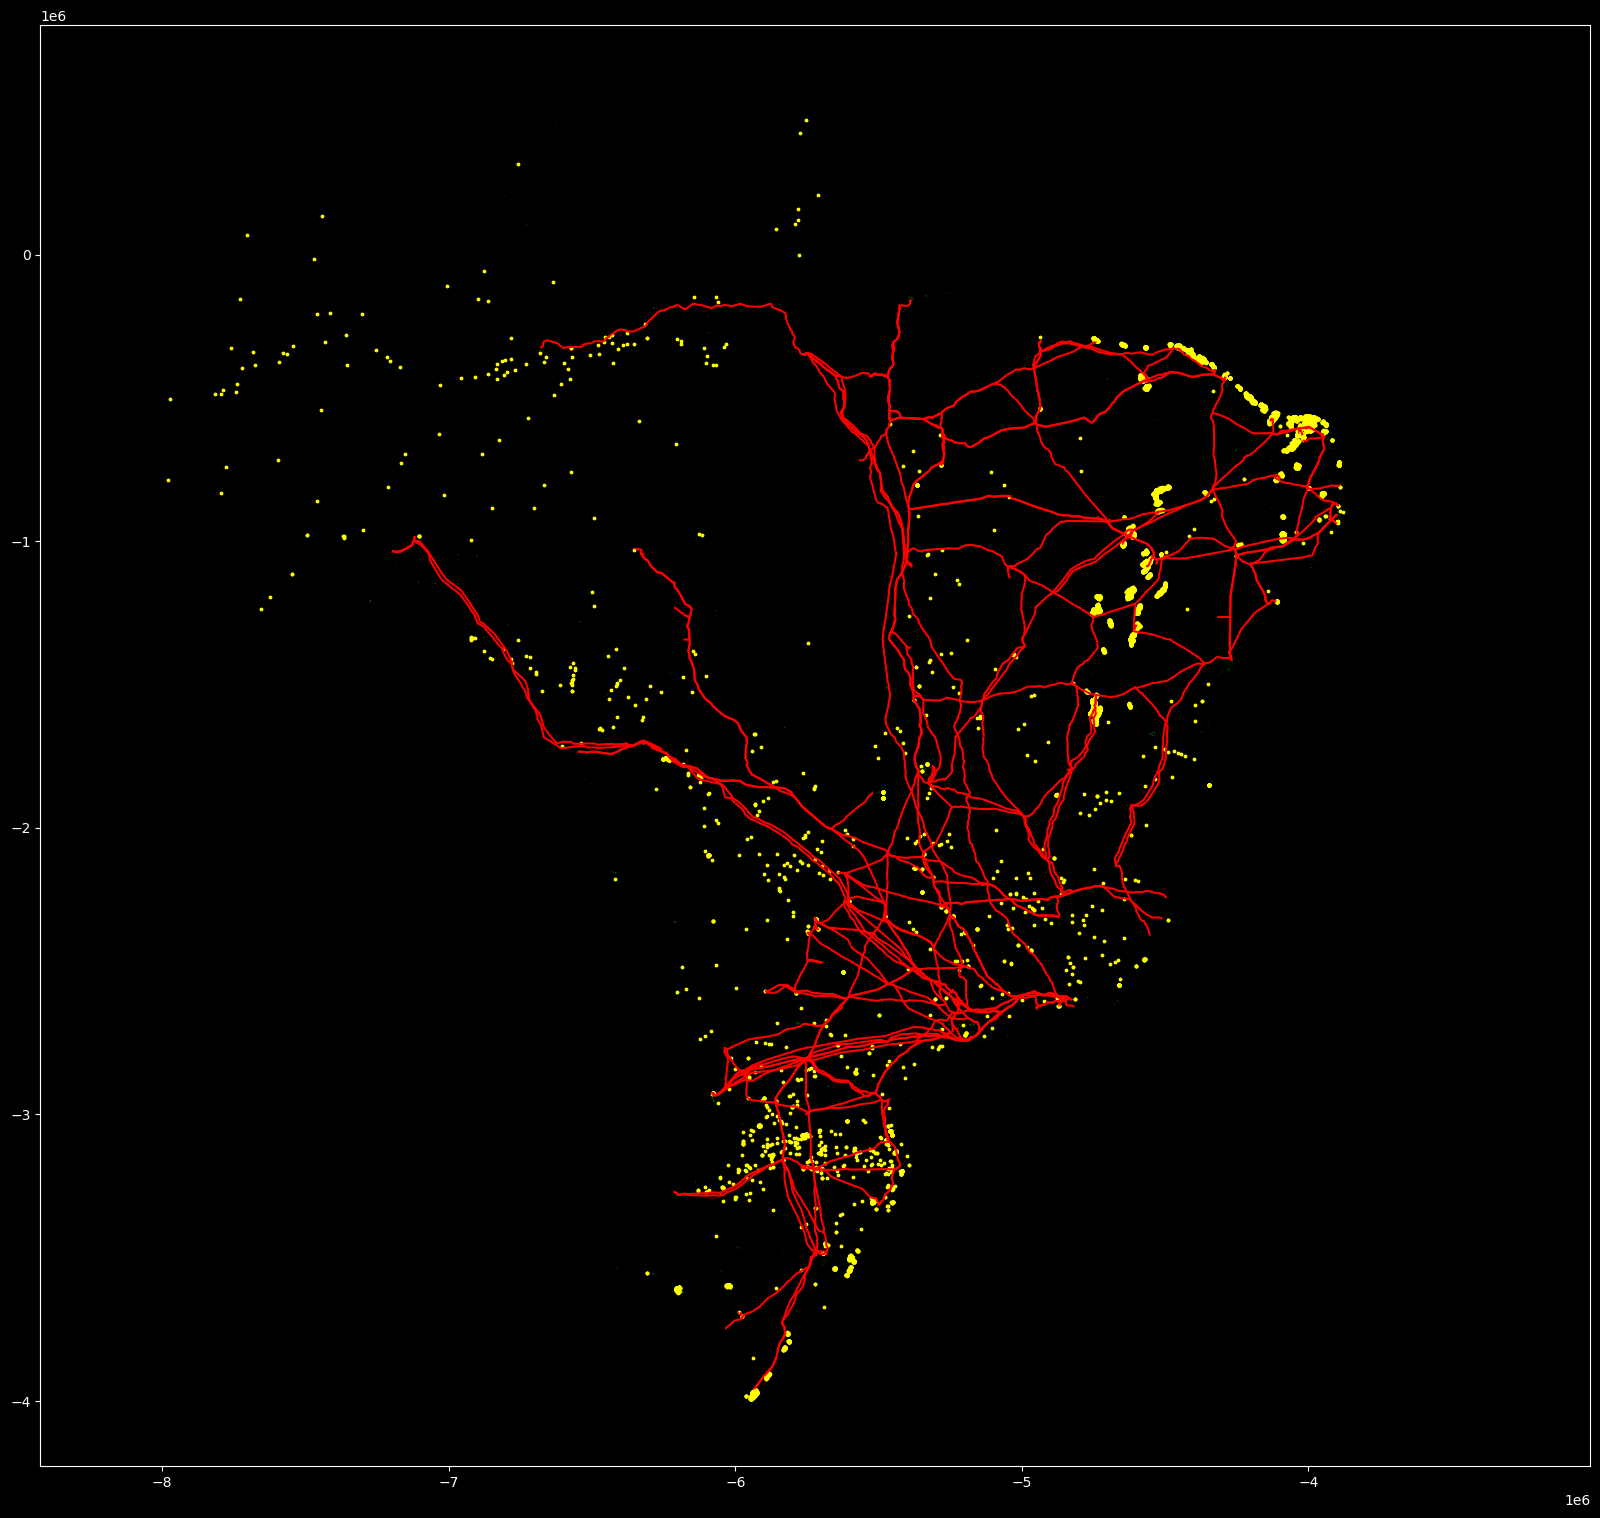

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
landuse.plot(ax=ax, color='green', markersize=3)
power.plot(ax=ax, color='red', markersize=3)
powergeneration.plot(ax=ax, color='yellow', markersize=3)

## constraints

In [ ]:
# this metereology mask is rater based and has the crs of the raster
metereology_mask = (wind_speed > 8) & (wind_speed < 12) & (power_density > 200)

In [ ]:

population_mask = population_density['Z'] < 1

In [21]:
wind_speed

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)

## optimization